In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Viewability VS Brand Matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# this allows plots to appear directly in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
# pip install patsy
# pip install statsmodels
import statsmodels.formula.api as smf
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

from IPython.core.display import display, HTML

In [152]:
# define url
url_0419 = '/Users/shaokuixing/Desktop/whatever/survey000_50_500_gender_20160419.csv'

# read csv file
rawData = pd.read_csv(url_0419, sep=';', thousands = '.', decimal =',')
#rawData.head(5).transpose()

from IPython.core.display import display, HTML
display(HTML('<h1>Click <a href="http://www.yahoo.com">here</a> to see Data File</h1>'))


## Transform Data Round 1
### - Extract brand matrix correlated question as a feature
### - Translate into both numerical and categorical features
### - Drop unnecessary columns
### - Populate missing data points, e.g. fill NAN data on totalviewtime as 0
### - Ad feature on Average Time Viewable per Viewable Impression

In [71]:
# del rawData
# rawData.head()

In [230]:
# subset recall
recall = rawData[rawData['questionid']==84].reset_index()
recall['recall'] = np.where(recall['ioptiontext']=='Yes',1,0).astype(int)
recall['recall_category'] = np.where(recall['ioptiontext']=='Yes','Yes','No')

# subset interest
interest = rawData[rawData['questionid']==86].reset_index()
interest['interest'] = pd.to_numeric(interest['ioptiontext'], errors='coerce')
interest['interest_category']=np.where(interest['interest']>=4,'High','Low')

# subset intent
intent = rawData[rawData['questionid']==83].reset_index()
intent['intent'] = pd.to_numeric(intent['ioptiontext'], errors='coerce')
intent['intent_category']=np.where(intent['intent'] >= 4 ,'High','Low')

# subset age
age = rawData[rawData['questionid']==90].reset_index()
age=age.rename(columns = {'ioptiontext':'age_category'})

# subset gender
gender = rawData[rawData['questionid']==91].reset_index()
gender=gender.rename(columns = {'ioptiontext':'gender_category'})

#gender.sample(n=1, random_state=1)


In [231]:
# drop unnecessary columns
recall.drop(recall[['ioptiontext','answerid','questionid','questiontext','optionid', 
                 'iscomplete','isrefgroup']],axis=1, inplace=True)
interest.drop(interest[['ioptiontext','answerid','questionid','questiontext','optionid', 
                 'iscomplete','isrefgroup']],axis=1, inplace=True)
intent.drop(intent[['ioptiontext','answerid','questionid','questiontext','optionid', 
              'iscomplete','isrefgroup']],axis=1, inplace=True)
age.drop(age[['answerid','questionid','questiontext','optionid','iscomplete','isrefgroup']],axis=1, inplace=True)
gender.drop(gender[['answerid','questionid','questiontext','optionid','iscomplete','isrefgroup']],axis=1, inplace=True)

In [232]:
# merge data
df = recall.merge(interest, 
on= ['surveyid','answersetid',  'click', 
     'firstinteraction', 'deliveredimp', 'viewableimp','viewableimp_ic','totalviewtime']).merge(intent, on= ['surveyid','answersetid',  'click', 
     'firstinteraction', 'deliveredimp', 'viewableimp','viewableimp_ic','totalviewtime']).merge(age, on= ['surveyid','answersetid',  'click', 
     'firstinteraction', 'deliveredimp', 'viewableimp','viewableimp_ic','totalviewtime']).merge(gender, on= ['surveyid','answersetid',  'click', 
     'firstinteraction', 'deliveredimp', 'viewableimp','viewableimp_ic','totalviewtime'])

#df.head()

In [233]:
# df.age_category.unique()

In [234]:
# create function to transform age column into numerical
def age_trans(x):
    if x['age_category'] == "15-24":
        val = 1
    elif x['age_category'] == "25-34":
        val = 2
    elif x['age_category'] == "35-44":
        val = 3
    elif x['age_category'] == "45-54":
        val = 4
    elif x['age_category'] == "55-64":
        val = 5
    else:
        val=6
    return val

In [235]:
# apply function
df['age'] = df.apply(age_trans, axis=1)
#df.sample(n=5, random_state=1)

# Data after transformation

In [236]:
# transform gender into numerical column
df['gender'] = np.where(df['gender_category']=="Male", 1, 0)
# df.sample(n=5, random_state=1)
df1= df[['surveyid', 'answersetid', 'recall','interest','intent','age', 'gender','recall_category','interest_category', 
         'intent_category', 'age_category','gender_category',
         'click','firstinteraction','deliveredimp', 'viewableimp', 'viewableimp_ic','totalviewtime']]
#df1.head()

In [237]:
#check if any value is nan
#df1.isnull().values.any()
#list all rows with nan values
#df1[pd.isnull(df1).any(axis=1)]
#fill nan values with 0
df1 = df1.fillna(0)
#df1.isnull().values.any()

In [238]:
df1['avgviewtime'] = df1['totalviewtime'].div(df['viewableimp_ic'], axis=0)
df1.fillna(0, inplace=True)
df1.head()

,surveyid,answersetid,recall,interest,intent,age,gender,recall_category,interest_category,intent_category,age_category,gender_category,click,firstinteraction,deliveredimp,viewableimp,viewableimp_ic,totalviewtime,avgviewtime
0,291,218047,1,2,5,1,0,Yes,Low,High,15-24,Female,0,0,4,3,2,8480,4240
1,291,218979,1,2,2,3,0,Yes,Low,Low,35-44,Female,0,0,2,1,1,850,850
2,291,219322,0,2,2,2,0,No,Low,Low,25-34,Female,0,0,1,0,0,0,0
3,291,219343,1,3,4,1,0,Yes,Low,High,15-24,Female,0,0,1,1,1,6220,6220
4,291,219622,1,1,3,1,0,Yes,Low,Low,15-24,Female,0,0,4,4,2,64798,32399


## Basic Descriptive Analysis of the data

In [239]:
df1[[ 'recall','interest','intent','age', 'gender','recall_category','interest_category', 
         'intent_category', 'age_category','gender_category',
         'click','firstinteraction','deliveredimp', 'viewableimp', 'viewableimp_ic','totalviewtime', 'avgviewtime']].describe()

,recall,interest,intent,age,gender,click,firstinteraction,deliveredimp,viewableimp,viewableimp_ic,totalviewtime,avgviewtime
count,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8.004000e+03,8004.000000
mean,0.387306,2.342954,2.517366,2.642804,0.432784,0.274113,0.790855,30.411169,21.035357,18.347326,1.172001e+06,80792.875381
std,0.487165,1.248545,1.393860,1.564386,0.495492,0.932737,4.858306,56.383385,39.026577,32.912871,9.244062e+06,548226.488016
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,2.548900e+04,5862.150000
50%,0.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,12.000000,8.000000,8.000000,1.205860e+05,11056.113636
75%,1.000000,3.000000,3.000000,4.000000,1.000000,0.000000,1.000000,33.000000,23.000000,20.000000,4.718020e+05,30501.958333
max,1.000000,5.000000,5.000000,6.000000,1.000000,27.000000,393.000000,1026.000000,760.000000,680.000000,6.898472e+08,36307746.684211


## Eliminating Outliers Round 1

In [297]:
# eliminate outliers above 80% percentile of frequency (number of viewable impression)
# eliminate outliers above 80% percentile average time viewable per impression
df2 = df1[(df1.viewableimp_ic < df1.viewableimp_ic.quantile(.80)) & (df1.avgviewtime < df1.avgviewtime.quantile(.80)) ]
df2.describe()

,surveyid,answersetid,recall,interest,intent,age,gender,click,firstinteraction,deliveredimp,viewableimp,viewableimp_ic,totalviewtime,avgviewtime
count,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000,5081.000000
mean,402.008069,314284.515647,0.374533,2.329069,2.513088,2.598307,0.416453,0.111986,0.251722,12.180673,7.980319,6.895493,88167.394411,10881.482527
std,60.538074,51052.188251,0.484050,1.235291,1.397085,1.565068,0.493019,0.430455,0.666559,13.572684,9.100446,6.690920,124252.761443,9753.752169
min,291.000000,216498.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,359.000000,275266.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,10224.000000,4312.750000
50%,402.000000,314674.000000,0.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,5.000000,41694.000000,8025.000000
75%,443.000000,346226.000000,1.000000,3.000000,3.000000,4.000000,1.000000,0.000000,0.000000,17.000000,12.000000,11.000000,116330.000000,14814.000000
max,528.000000,506461.000000,1.000000,5.000000,5.000000,6.000000,1.000000,8.000000,8.000000,172.000000,171.000000,25.000000,1039672.000000,43910.222222


In [298]:
#df2.sample(n=5, random_state=0)

In [299]:
# check if the join works
#df.loc[df['column_name'].isin(some_values)]
#df.loc[df['column_name'] != some_value]
#df2.loc[df2['answersetid'] == 239890]

In [300]:
#recall.loc[recall['answersetid'] == 239890]

In [301]:
#interest.loc[interest['answersetid'] == 239890]

In [302]:
#intent.loc[intent['answersetid'] == 239890]

In [303]:
#age.loc[age['answersetid'] == 239890]

In [304]:
#gender.loc[gender['answersetid'] == 239890]

In [305]:
# select useful columns
df3 = df2[df2.columns[1:]]
# change view time into seconds
df3.is_copy = False
df3['avgviewtime'] = df3['avgviewtime']/1000
df3['totalviewtime'] = df3['totalviewtime']/1000
#df3.head()

In [306]:
#df3['recall_category']=pd.to_numeric(df3['recall_category'], errors='coerce')
#df3['interest_category']=pd.to_numeric(df3['interest_category'], errors='coerce')
#df3['intent_category']=pd.to_numeric(df3['intent_category'], errors='coerce')


## Spearman Rank Correlation Coefficient Heatmap
### Let's take a look if there is any correlation among each feature

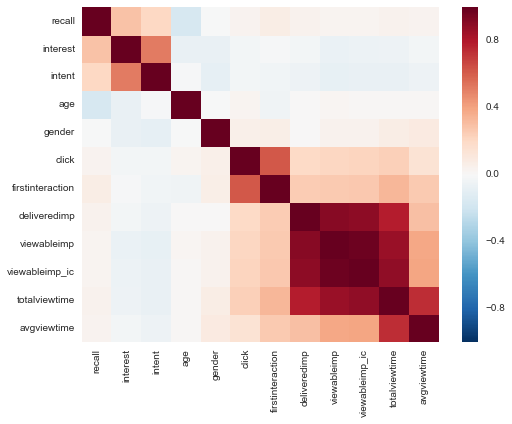

In [307]:
sns.heatmap(df3[df3.columns[1:]].corr(method='spearman'))

In [332]:
# Factorize categorical data
# df3.head(1)
df3['interest_category_num']=pd.factorize(df3['interest_category'])[0]
df3['intent_category_num']=pd.factorize(df3['intent_category'])[0]
df3['intent_category_num'] = np.where(df3['intent_category_num']==1,0,1)
#df3.sample(n=5, random_state=1)

In [333]:
# bining
#df3 = df3.reindex(np.zeros(len(df3)))
#df3['totalVTBin'] = pd.qcut(df3['totalviewtime'], 4)
#df3['totalVTBin_id'] = pd.factorize(df3['totalVTBin'])
#df3.head()

In [334]:
#df_25 = df3[ df3.avgviewtime < df3.avgviewtime.quantile(.25) ]
#sns.heatmap(df_25[df_25.columns[1:]].corr(method='spearman'))

In [405]:
#categorical cut on avgviewtime
labels = [ "{0} - {1}".format(i, i + 2) for i in range(0, 120, 2) ]
print labels
df3['avgVTCategory'] = pd.cut(df3.avgviewtime, range(0, 121, 2), right=False, labels=labels)
df3[['avgviewtime','avgVTCategory']].sample(n=20, random_state=0)

['0 - 2', '2 - 4', '4 - 6', '6 - 8', '8 - 10', '10 - 12', '12 - 14', '14 - 16', '16 - 18', '18 - 20', '20 - 22', '22 - 24', '24 - 26', '26 - 28', '28 - 30', '30 - 32', '32 - 34', '34 - 36', '36 - 38', '38 - 40', '40 - 42', '42 - 44', '44 - 46', '46 - 48', '48 - 50', '50 - 52', '52 - 54', '54 - 56', '56 - 58', '58 - 60', '60 - 62', '62 - 64', '64 - 66', '66 - 68', '68 - 70', '70 - 72', '72 - 74', '74 - 76', '76 - 78', '78 - 80', '80 - 82', '82 - 84', '84 - 86', '86 - 88', '88 - 90', '90 - 92', '92 - 94', '94 - 96', '96 - 98', '98 - 100', '100 - 102', '102 - 104', '104 - 106', '106 - 108', '108 - 110', '110 - 112', '112 - 114', '114 - 116', '116 - 118', '118 - 120']


,avgviewtime,avgVTCategory
659,19.505818,18 - 20
5016,19.361333,18 - 20
772,0.000000,0 - 2
1056,4.681143,4 - 6
158,5.637167,4 - 6
5767,10.357333,10 - 12
6253,16.842000,16 - 18
75,6.435500,6 - 8
720,11.353600,10 - 12
1713,10.708000,10 - 12


In [406]:
#df3.sample(n=5, random_state=1)

In [407]:
#pd.crosstab(df3.recall, df3.avgVTCategory_num)

In [408]:
# substring column value
#df3.avgVTCategory.str[:3]
d3['avgVTCategory_num']=df3.avgVTCategory.str.split('-').str[0]

d3.sample(n=5, random_state=1)

,answersetid,recall,interest,intent,age,gender,recall_category,interest_category,intent_category,age_category,gender_category,click,firstinteraction,deliveredimp,viewableimp,viewableimp_ic,totalviewtime,avgviewtime,avgVTCategory_num
2070,287122,0,3,3,5,0,No,Low,Low,55-64,Female,0,0,8,3,4,27040,6760.000000,6
2894,297103,0,1,1,1,0,No,Low,Low,15-24,Female,0,0,35,23,23,99610,4330.869565,4
3743,318673,0,4,4,1,0,No,High,High,15-24,Female,0,0,13,12,10,133604,13360.400000,12
1208,252099,0,3,5,1,0,No,Low,High,15-24,Female,0,0,5,3,4,138746,34686.500000,34
655,239767,1,4,5,1,0,Yes,High,High,15-24,Female,0,0,11,10,9,109720,12191.111111,12


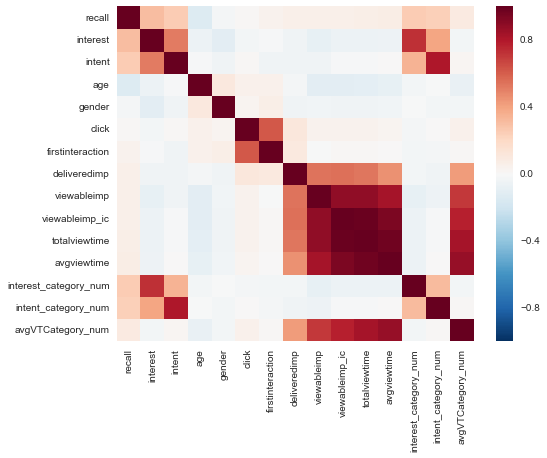

In [409]:
df_25 = df3[ df3.avgviewtime < df3.avgviewtime.quantile(.20) ]
sns.heatmap(df_25[df_25.columns[1:]].corr(method='spearman'))

In [410]:
from pivottablejs import pivot_ui
pivot_ui(df3)